# Preprocessing

Data exploration of ADNI patients. This notebooks merges all available information extracted from ADNI database and ensures data is ready for further processing.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import kruskal

np.random.seed(0)

### Data merging

In [2]:
def process_df(phase):
    # Load data
    df_features = pd.read_table('../DATA/processed_data_adni%d.tsv'%phase, sep=' ').dropna()
    df_patient_list = pd.read_table('../DATA/participants_adni%d.tsv'%phase, names=['Subject', 'PTID'])
    df_metadata = pd.read_csv('../DATA/adni%d_mri.csv'%phase, index_col=0)
    df_conversors = pd.read_csv('../DATA/adni%d_conversors.csv'%phase, index_col=0)
    
    # Combine left and right structures to single structure
    structures = ['Thalmus', 'Caudate', 'Putamen', 'Palidum', 
            'Hippo', 'Amygdala', 'Accumbens']
    for s in structures:
        df_features[s] = df_features['L_%s'%s]+df_features['R_%s'%s]
    
    df_full = df_patient_list.merge(df_features, on='Subject')\
                             .merge(df_metadata, on='PTID')\
                             .merge(df_conversors, on='RID')
                                                                 
    # Remove sites that do not contain alzeihmers patient
    all_sites = set(df_full['SITEID'])
    ad_sites = set(df_full[df_full['DIAGNOSIS']==3.0]['SITEID'])
    missing_sites = [site for site in all_sites if site not in ad_sites]
    df_full = df_full[df_full['SITEID'].isin(missing_sites) == False]
    
    # Get back non-normalized (raw features) and rename
    for f in ['Brain_norm', 'GM_norm', 'WM_norm',
        'vscf_norm', 'pgrey_norm']:
        df_full[f] = df_full[f]/df_full['Vscale']
    df_full.rename(columns={'Brain_norm':'Brain_size', 'GM_norm': 'GM', 
                            'WM_norm':'WM', 'vscf_norm':'vscf', 'pgrey_norm':'pgrey'}, inplace=True)

    # Change gender and phase assigment
    df_full['PTGENDER'].replace(['Female','Male'],[0,1],inplace=True)
    df_full['Phase'].replace(['ADNI2','ADNI3'],[0,1],inplace=True)

    return df_full

# Create dataframes for each phase
df_full_adni2 = process_df(2)
df_full_adni3 = process_df(3)

# Concatenate dataframes
pd.set_option('display.max_columns', None)
df_full = pd.concat([df_full_adni2, df_full_adni3], ignore_index=True)
df_full = df_full.drop_duplicates('RID', keep='first') # keep ADNI2 if duplciates

### Site analysis

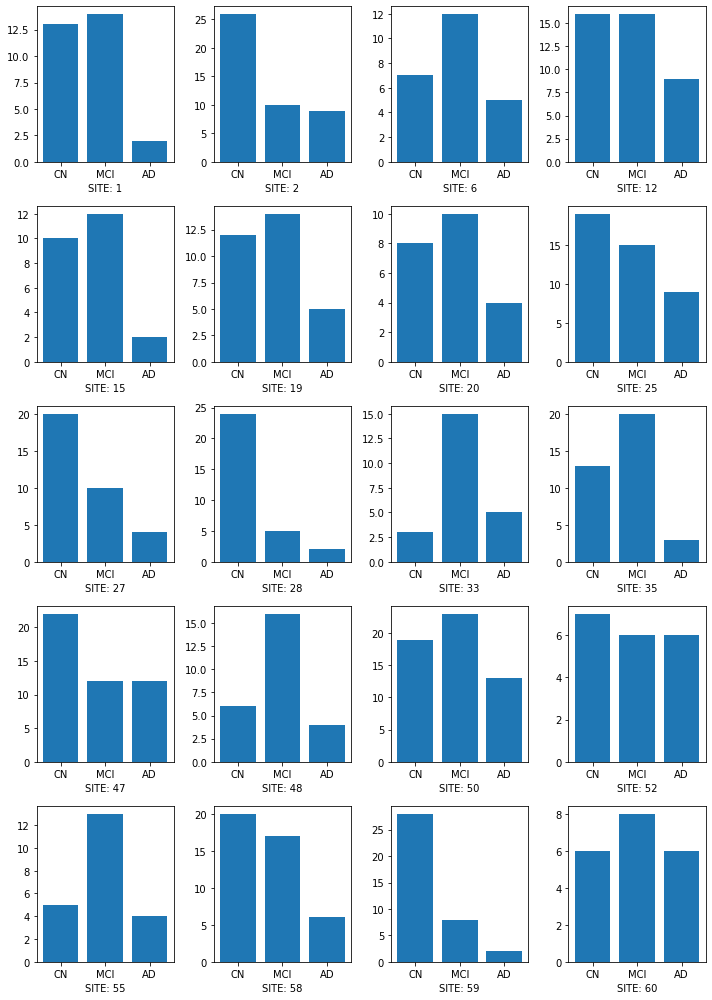

In [3]:
plt.figure(figsize=(10,14))
names = ['CN', 'MCI', 'AD']
sites = set(df_full['SITEID'])
for i, site in enumerate(sites):
    # Explor variability of features by site
    plt.subplot(5,4,i+1)
    df_site = df_full[df_full['SITEID']==site]
    vals = [np.sum(df_site['DIAGNOSIS']==diag) for diag in [1.0, 2.0, 3.0]]
    plt.bar(names, vals)
    plt.xlabel('SITE: %d' %site)
    plt.tight_layout()

Site 33 has too few controls to be able to model site variability effects so we will remove it.

In [4]:
df_full = df_full[df_full['SITEID'].isin([33]) == False]

### Age distribution

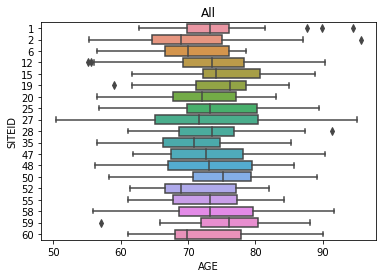

In [5]:
# Show age distribution by site
plt.figure()
plt.title('All')
ax = sns.boxplot(x='AGE', y='SITEID', data=df_full, orient='h')
plt.show()

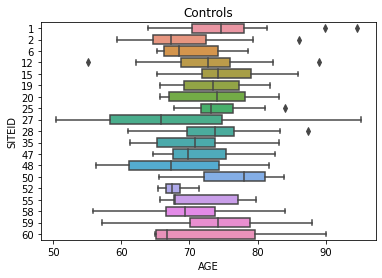

In [6]:
# Show age distribution by site
plt.figure()
plt.title('Controls')
ax = sns.boxplot(x='AGE', y='SITEID', data=df_full[df_full['DIAGNOSIS']==1.0], orient='h')
plt.show()

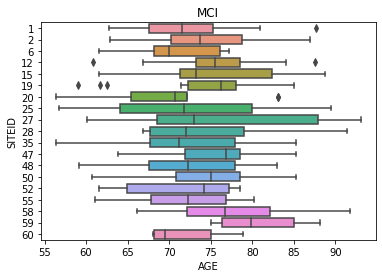

In [7]:
# Show age distribution by site
plt.figure()
plt.title('MCI')
ax = sns.boxplot(x='AGE', y='SITEID', data=df_full[df_full['DIAGNOSIS']==2.0], orient='h')
plt.show()

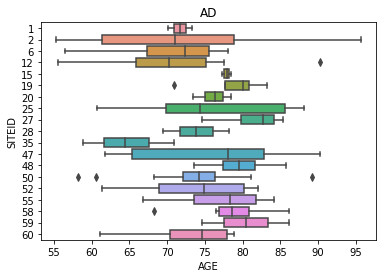

In [8]:
# Show age distribution by site
plt.figure()
plt.title('AD')
ax = sns.boxplot(x='AGE', y='SITEID', data=df_full[df_full['DIAGNOSIS']==3.0], orient='h')
plt.show()

The age distributions are different for each site. However, most importantly is to look at the age distirbutions overall of all the data.

p-value of age distributions
CN vs MCI: 0.012387
CN vs AD: 0.003696
MCI vs AD: 0.299219


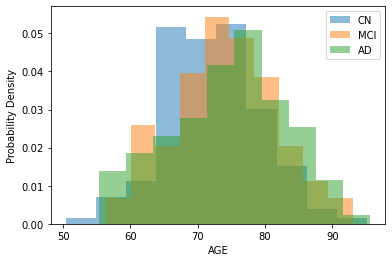

In [9]:
# Check p-values between groups for age
cn_age = df_full[df_full['DIAGNOSIS']==1.0]['AGE'].to_numpy()
mci_age = df_full[df_full['DIAGNOSIS']==2.0]['AGE'].to_numpy()
ad_age = df_full[df_full['DIAGNOSIS']==3.0]['AGE'].to_numpy()

print('p-value of age distributions')
hstat_cnvsmci_age, pval_cnvsmci_age = kruskal(cn_age, mci_age)
hstat_cnvsad_age, pval_cnvsad_age = kruskal(cn_age, ad_age)
hstat_mcivsad_age, pval_mcivsad_age = kruskal(ad_age, mci_age)
print('CN vs MCI: %f' % pval_cnvsmci_age)
print('CN vs AD: %f' % pval_cnvsad_age)
print('MCI vs AD: %f' % pval_mcivsad_age)

plt.hist(cn_age, label='CN', density=True, alpha=0.5)
plt.hist(mci_age, label='MCI', density=True, alpha=0.5)
plt.hist(ad_age, label='AD', density=True, alpha=0.5)
plt.xlabel('AGE')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

MCI and AD distributions are similar but not with CNs. Hence, we can subsample the controls to obtain a similar age distribution based on the AD distributions which is the most different from CN. We try three different strategies. The first two are based on the fact that the control age distribution is biased with more samples below 75 years old than the other two. The third is based on distribution matchin by subsampling.

In [10]:
def optimize_sampling(sampling_strategy, samples, target_dist, thr_pval, **kwargs):
    for sample_size in range(len(samples), 0, -1):
        new_samples = sampling_strategy(samples, sample_size, **kwargs)
        hstat, pval = kruskal(new_samples, target_dist)
        if pval > thr_pval:
            return new_samples, sample_size

New sample size: 249


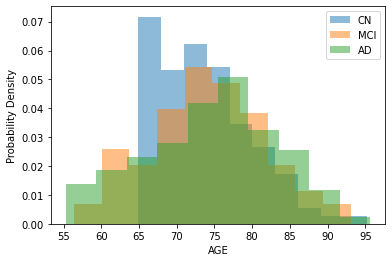

In [11]:
def sort_remove_young(samples, sample_size):
    sorted_samples = np.sort(samples)
    return sorted_samples[len(samples)-sample_size:]

new_samples, sample_size = optimize_sampling(sort_remove_young, cn_age, ad_age, 0.1)

print('New sample size: %d' % sample_size)

plt.hist(new_samples, label='CN', density=True, alpha=0.5)
plt.hist(mci_age, label='MCI', density=True, alpha=0.5)
plt.hist(ad_age, label='AD', density=True, alpha=0.5)
plt.xlabel('AGE')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

Although the null hypothesis will not be rejected by visual inspection the CN distribution looks very different to the rest so rather than just removing the younger ones we can subsample from those below the average of the distribution.

New sample size: 234


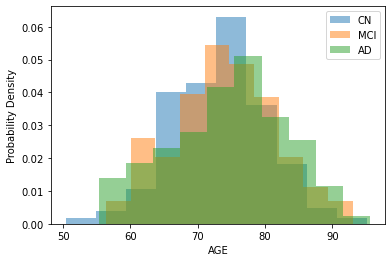

In [12]:
def remove_young_subsampling(samples, sample_size, cutoffage):
    sorted_samples = np.sort(samples)
    cutoff = np.argmax(sorted_samples>cutoffage)
    lower = sorted_samples[:cutoff]
    upper = sorted_samples[cutoff:]
    resampling_size = len(lower)-(len(samples)-sample_size)
    new_lower = np.random.choice(lower, size=resampling_size, replace=False, )
    return  np.concatenate([new_lower, upper])

cutoffage = np.mean(cn_age)
new_samples, sample_size = optimize_sampling(remove_young_subsampling, cn_age, ad_age, 0.1, cutoffage=cutoffage)

print('New sample size: %d' % sample_size)

plt.hist(new_samples, label='CN', density=True, alpha=0.5)
plt.hist(mci_age, label='MCI', density=True, alpha=0.5)
plt.hist(ad_age, label='AD', density=True, alpha=0.5)
plt.xlabel('AGE')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

The number of samples has been reduced by only 15 more but the shapes now visually look more similar.

New sample size: 204


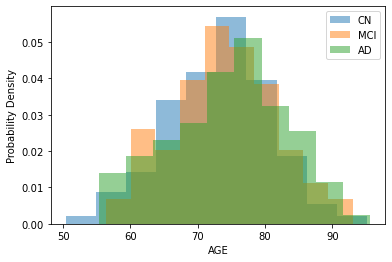

In [13]:
def subsampling_matching(samples, sample_size, subsampling_dist, N_BINS):
    # Obtain `N_BINS` equal frequency bins, in other words percentiles
    step = 100 / N_BINS
    test_percentiles = [
        np.percentile(subsampling_dist, q, axis=0)
        for q in np.arange(start=0, stop=100, step=step)
    ]

    # Match each observation in the training set to a bin
    train_bins = np.digitize(samples, test_percentiles)

    # Count the number of values in each training set bin
    train_bin_counts = np.bincount(train_bins)

    # Weight each observation in the training set based on which bin it is in
    weights = 1 / np.array([train_bin_counts[x] for x in train_bins])

    # Make the weights sum up to 1
    weights_norm = weights / np.sum(weights)

    np.random.seed(0)
    sample = np.random.choice(cn_age, size=sample_size, p=weights_norm, replace=False)
    
    return sample

new_samples, sample_size = optimize_sampling(subsampling_matching, cn_age, ad_age, 0.1,
                                             N_BINS=15, subsampling_dist=ad_age)

print('New sample size: %d' % sample_size)

plt.hist(new_samples, label='CN', density=True, alpha=0.5)
plt.hist(mci_age, label='MCI', density=True, alpha=0.5)
plt.hist(ad_age, label='AD', density=True, alpha=0.5)
plt.xlabel('AGE')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

Now the distributions are matched very well but at the cost of removing too many samples. Hence the second strategy will be employed.

In [14]:
df_cn = df_full[df_full['DIAGNOSIS']==1.0]
ages = df_cn['AGE'].to_numpy()
rids = df_cn['RID'].to_numpy()
# Add some small noise so that all the ages are different so that we can match to correct rid later
ages_noise = ages+np.random.normal(0, 0.01, len(ages))
cutoffage = np.mean(ages_noise)
new_samples, sample_size = optimize_sampling(remove_young_subsampling, ages_noise, ad_age, 0.1, cutoffage=cutoffage)
ages_loc = [np.where(age == ages_noise)[0][0] for age in new_samples]
rid_keep = rids[ages_loc]
remove_ids = [rid for rid in rids if not rid in rid_keep]
df_full = df_full[~df_full['RID'].isin(remove_ids)]
df_full.to_csv('../DATA/adni_full_data.csv')